## Categorising countries

### Data Source

The data used in this task was orginally sourced from Help.NGO. This international non-governmental organisation specialises in emergency response, preparedness, and risk mitigation.  

### Dataset Attributes
- country: name of the country
- child_mort: death of children under 5 years of age per 1000 live births
- exports: exports of goods and services per capita. Given as a percentage of the GDP per capita
- health: total health spending per capita. Given as a percentage of GDP per capita
- imports: imports of goods and services per capita. Given as a percentage of the GDP per capita
- income: net income per person
- inflation: the measurement of the annual growth rate of the Total GDP
- life_expec: the average number of years a new born child would live if the current mortality patterns remain the same
- total_fer: the number of children that would be born to each woman if the current age-fertility rates remains the same
- gdpp: the GDP per capita. Calculated as the Total GDP divided by the total population.

## Objective  
To group countries using socio-economic and health factors to determine the development status of the country.

In [1]:
# Import libraries
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)
import os

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Random state seed
rseed = 42

## Load and explore data

In [3]:
# Import the dataset
df = pd.read_csv('Country-data.csv',index_col=0)

In [4]:
# Check the shape
print('Data:')
print(df.head(), end='\n\n')

Data:
                     child_mort  exports  health  imports  income  inflation  \
country                                                                        
Afghanistan                90.2     10.0    7.58     44.9    1610       9.44   
Albania                    16.6     28.0    6.55     48.6    9930       4.49   
Algeria                    27.3     38.4    4.17     31.4   12900      16.10   
Angola                    119.0     62.3    2.85     42.9    5900      22.40   
Antigua and Barbuda        10.3     45.5    6.03     58.9   19100       1.44   

                     life_expec  total_fer   gdpp  
country                                            
Afghanistan                56.2       5.82    553  
Albania                    76.3       1.65   4090  
Algeria                    76.5       2.89   4460  
Angola                     60.1       6.16   3530  
Antigua and Barbuda        76.8       2.13  12200  



In [5]:
# Check datatypes & counts
print(df.info(), end='\n\n')

<class 'pandas.core.frame.DataFrame'>
Index: 167 entries, Afghanistan to Zambia
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   child_mort  167 non-null    float64
 1   exports     167 non-null    float64
 2   health      167 non-null    float64
 3   imports     167 non-null    float64
 4   income      167 non-null    int64  
 5   inflation   167 non-null    float64
 6   life_expec  167 non-null    float64
 7   total_fer   167 non-null    float64
 8   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2)
memory usage: 13.0+ KB
None



In [6]:
# Get descriptive statistics
print(df.describe(), end='\n\n')

       child_mort     exports      health     imports         income  \
count  167.000000  167.000000  167.000000  167.000000     167.000000   
mean    38.270060   41.108976    6.815689   46.890215   17144.688623   
std     40.328931   27.412010    2.746837   24.209589   19278.067698   
min      2.600000    0.109000    1.810000    0.065900     609.000000   
25%      8.250000   23.800000    4.920000   30.200000    3355.000000   
50%     19.300000   35.000000    6.320000   43.300000    9960.000000   
75%     62.100000   51.350000    8.600000   58.750000   22800.000000   
max    208.000000  200.000000   17.900000  174.000000  125000.000000   

        inflation  life_expec   total_fer           gdpp  
count  167.000000  167.000000  167.000000     167.000000  
mean     7.781832   70.555689    2.947964   12964.155689  
std     10.570704    8.893172    1.513848   18328.704809  
min     -4.210000   32.100000    1.150000     231.000000  
25%      1.810000   65.300000    1.795000    1330.000000

In [7]:
# Identify any missing data
print(df.isnull().sum(), end='\n\n')

child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64



## Preprocessing and Feature Selection

Drop any non-numeric columns from the dataset.

In [8]:
# Prepare data for clustering, note that we do not supply y in an unsupervised learning task.
# Drop any non-numeric features (columns)
if 'country' in df.columns:
    df_numeric = df.drop(columns=['country'])
else:
    df_numeric = df

# Check the dataframe without the 'country' column
print(df_numeric.head(), end='\n\n')

                     child_mort  exports  health  imports  income  inflation  \
country                                                                        
Afghanistan                90.2     10.0    7.58     44.9    1610       9.44   
Albania                    16.6     28.0    6.55     48.6    9930       4.49   
Algeria                    27.3     38.4    4.17     31.4   12900      16.10   
Angola                    119.0     62.3    2.85     42.9    5900      22.40   
Antigua and Barbuda        10.3     45.5    6.03     58.9   19100       1.44   

                     life_expec  total_fer   gdpp  
country                                            
Afghanistan                56.2       5.82    553  
Albania                    76.3       1.65   4090  
Algeria                    76.5       2.89   4460  
Angola                     60.1       6.16   3530  
Antigua and Barbuda        76.8       2.13  12200  



Plot eight different scatter plots with different combinations of variables against GDPP.

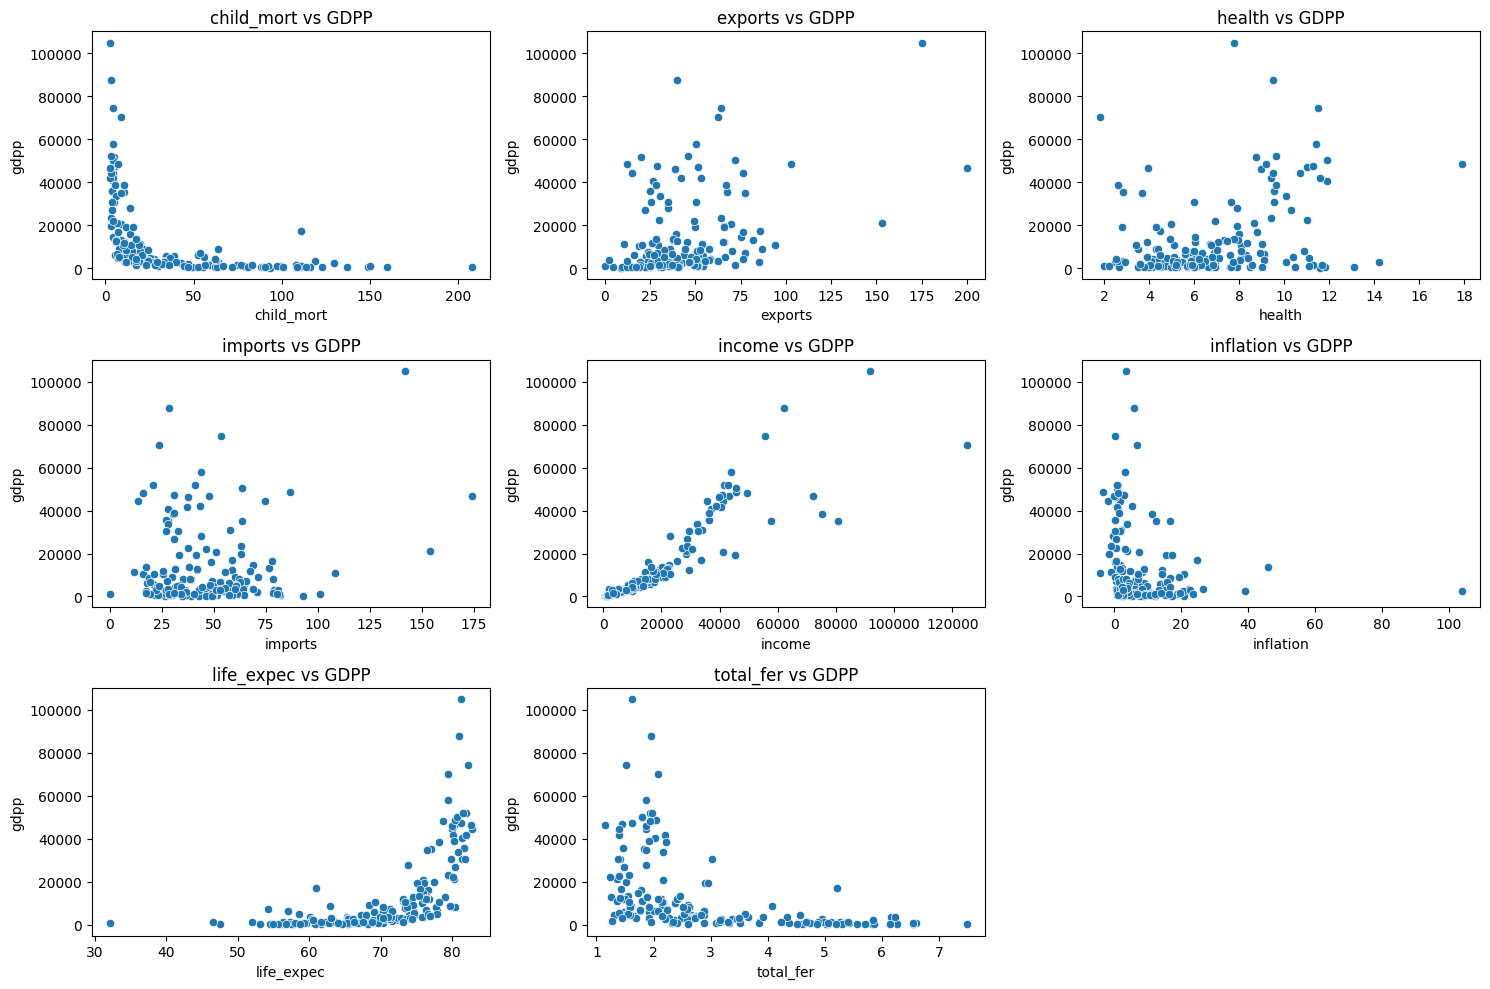

In [11]:
# Plot scatter plots with GDPP
columns = ['child_mort', 'exports', 'health', 'imports', 'income', 'inflation', 'life_expec', 'total_fer']

plt.figure(figsize=(15, 10))
for i, col in enumerate(columns, 1):
    plt.subplot(3, 3, i)
    sns.scatterplot(x=df[col], y=df['gdpp'])
    plt.title(f'{col} vs GDPP')

plt.tight_layout()
plt.show()

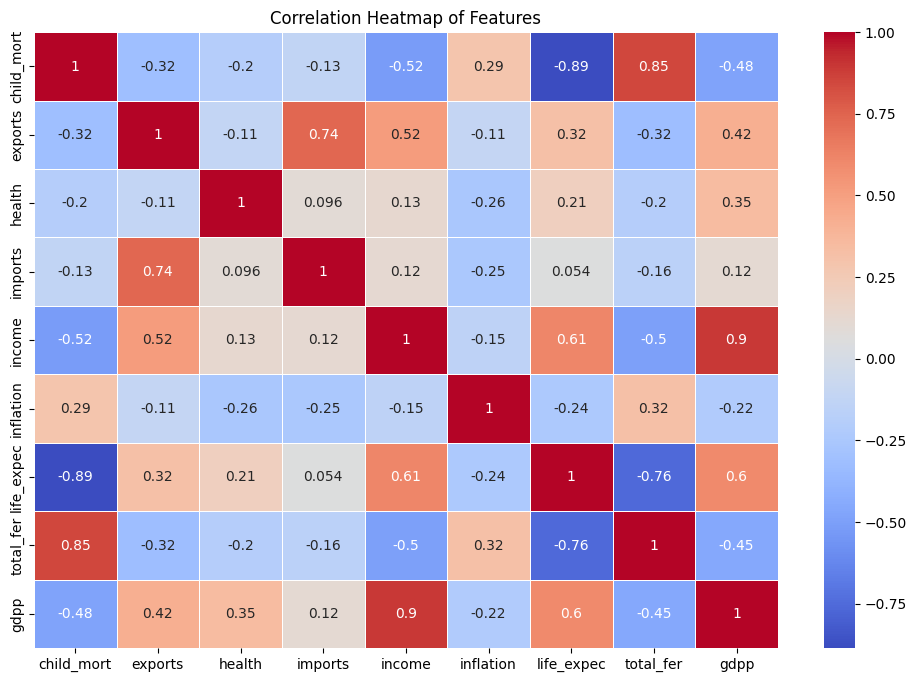

In [12]:
# Create a correlation map of features to explore relationships between features
correlation_matrix = df_numeric.corr() # create a correlation matrix

# Hint: Explore seaborn heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of Features')
plt.show()

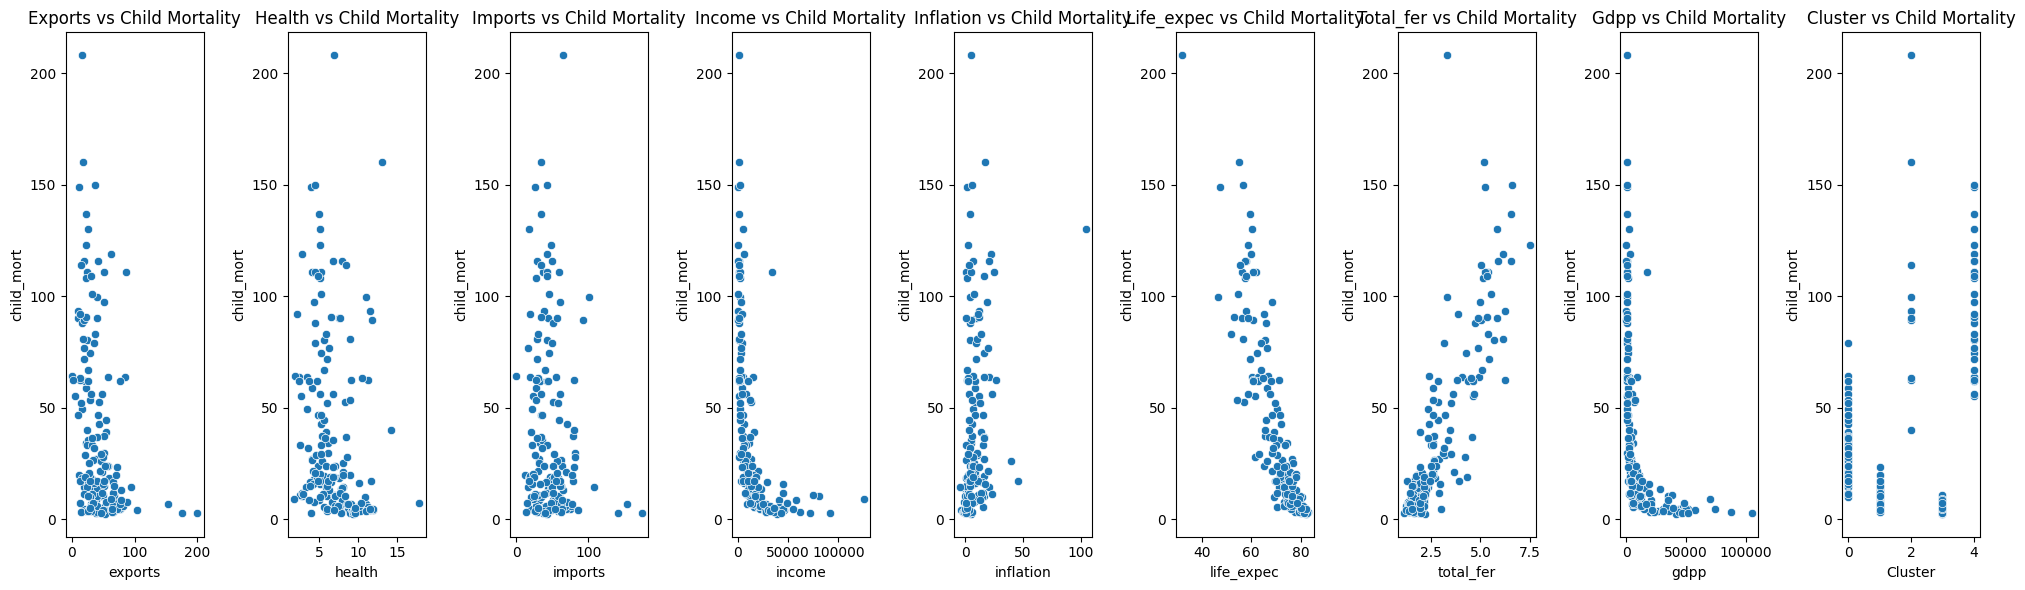

In [32]:
# Explore the continuous independent features against child_mort using scatter plots.
fig, axs = plt.subplots(1, len(df.columns[df.dtypes != 'object']) - 1, figsize=(20, 6))  # Adjust the size as needed

# List of continuous features (excluding 'country')
continuous_features = df.columns[df.dtypes != 'object'].tolist()

# Remove 'child_mort' from continuous features since we are plotting against it
continuous_features.remove('child_mort')

# Loop through each continuous feature and plot against child_mort
for i, feature in enumerate(continuous_features):
    sns.scatterplot(x=feature, y='child_mort', data=df, ax=axs[i])
    axs[i].set_title(f'{feature.capitalize()} vs Child Mortality')

plt.tight_layout()
plt.show()

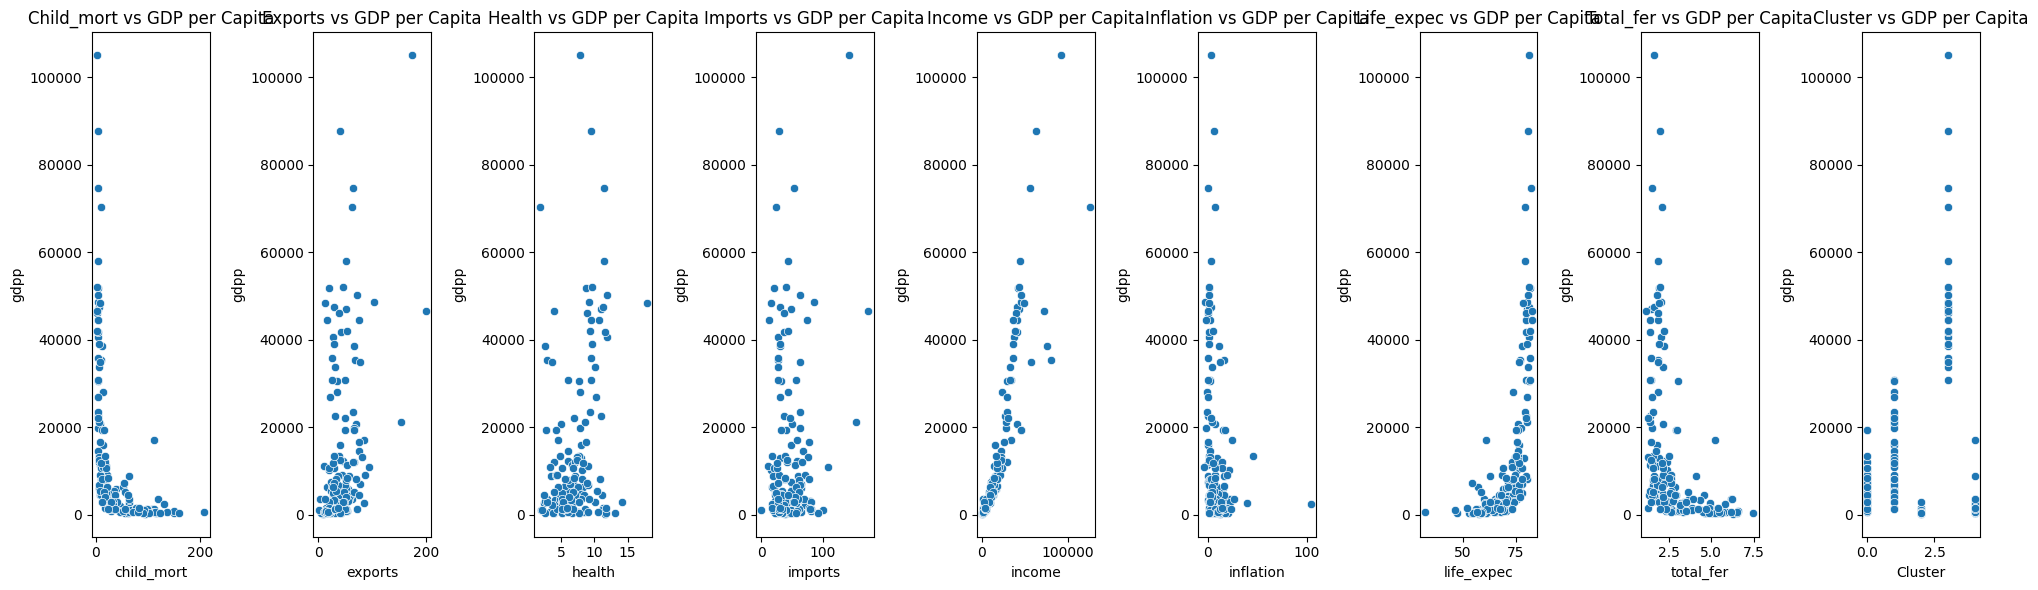

In [33]:
# Explore the continuous independent features against gdpp using scatter plots.
continuous_features = df.columns[df.dtypes != 'object'].tolist()
continuous_features.remove('gdpp') # Extract continuous features excluding 'gdpp'

# Scatter plots for each continuous feature against gdpp
fig, axs = plt.subplots(1, len(continuous_features), figsize=(20, 6))

for i, feature in enumerate(continuous_features):
    sns.scatterplot(x=feature, y='gdpp', data=df, ax=axs[i])
    axs[i].set_title(f'{feature.capitalize()} vs GDP per Capita')

plt.tight_layout()
plt.show()

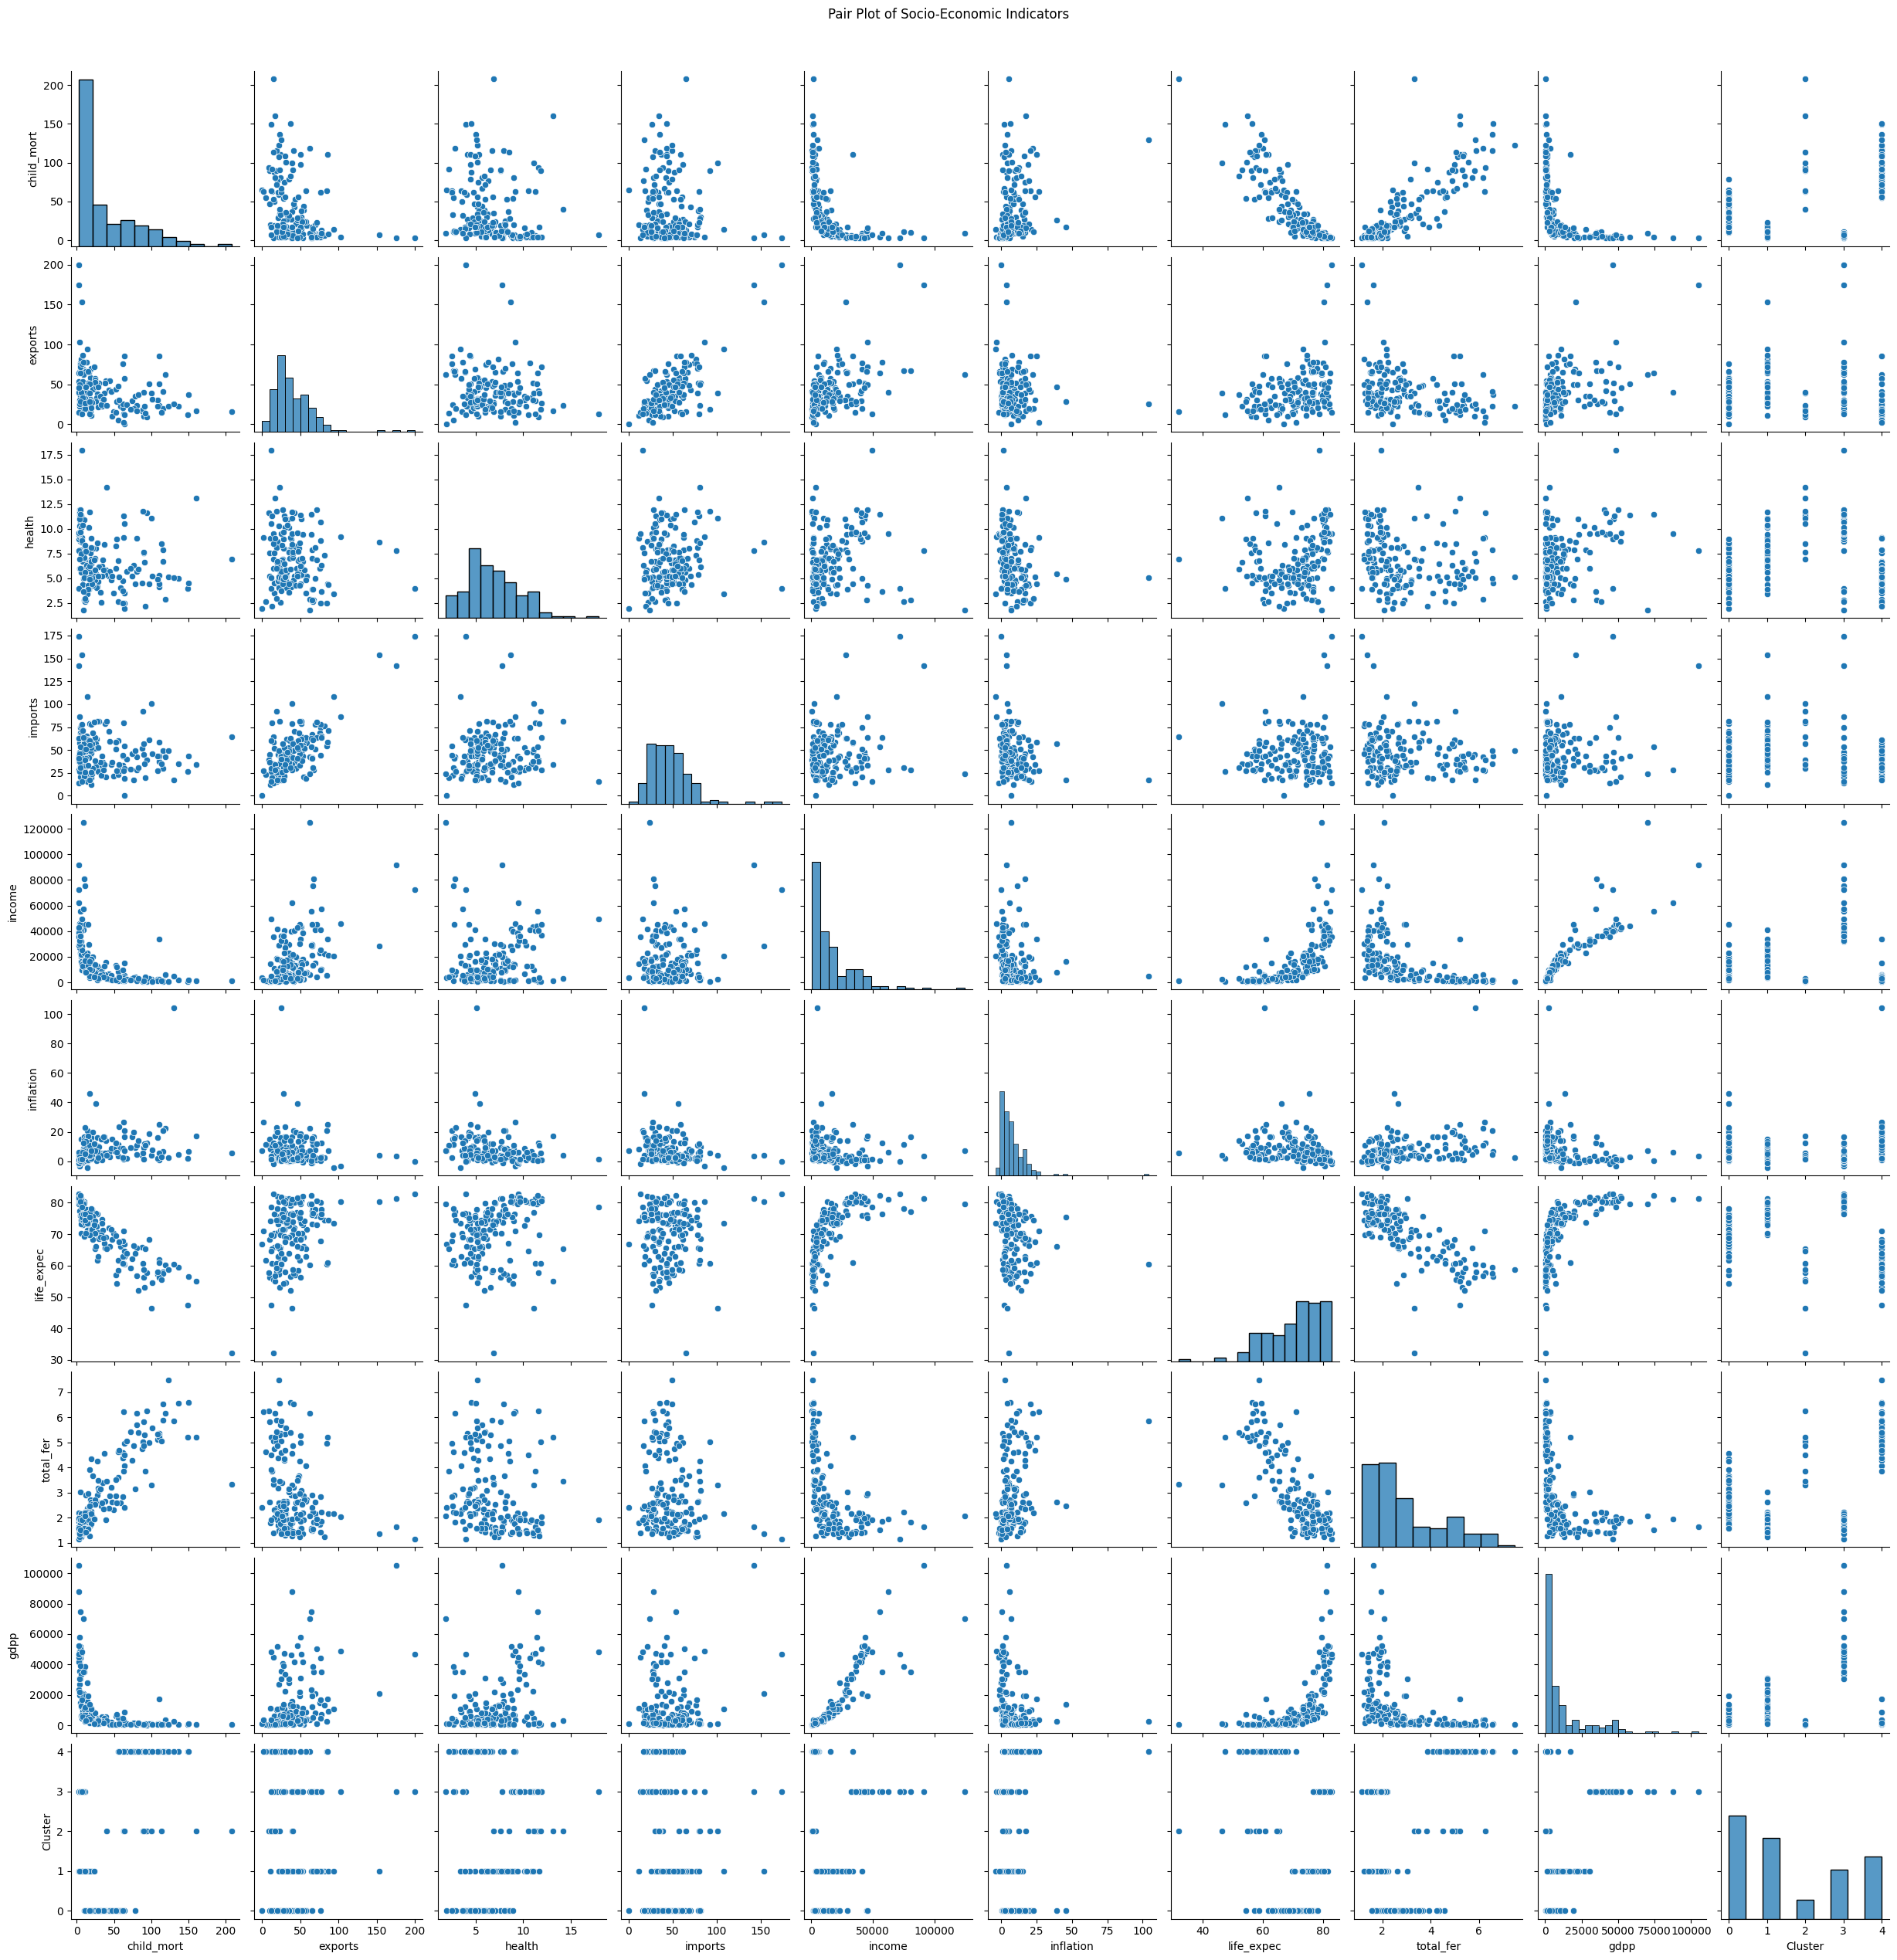

In [34]:
# Create a pair plot
# Hint: Explore seaborn pairplot
sns.pairplot(df)
plt.suptitle('Pair Plot of Socio-Economic Indicators', y=1.02)
plt.show()

Note the peaks in the diagonal graphs that are distinct from each other or only overlap slightly. Looking at the scatter plot distributions may also give you some indication of features that would be good candidates for clustering the data.

### Scaling the Data

Normalize the dataset using MinMaxScaler from sklearn.

In [16]:
# Normalise the data using MinMaxScaler
scaler = MinMaxScaler()
# Name the normalised dataframe "df_scaled"
df_scaled = pd.DataFrame(scaler.fit_transform(df_numeric), columns=df_numeric.columns) # Scale the data

# Display the first few rows of the scaled dataframe
print(df_scaled.head())

   child_mort   exports    health   imports    income  inflation  life_expec  \
0    0.426485  0.049482  0.358608  0.257765  0.008047   0.126144    0.475345   
1    0.068160  0.139531  0.294593  0.279037  0.074933   0.080399    0.871795   
2    0.120253  0.191559  0.146675  0.180149  0.098809   0.187691    0.875740   
3    0.566699  0.311125  0.064636  0.246266  0.042535   0.245911    0.552268   
4    0.037488  0.227079  0.262275  0.338255  0.148652   0.052213    0.881657   

   total_fer      gdpp  
0   0.736593  0.003073  
1   0.078864  0.036833  
2   0.274448  0.040365  
3   0.790221  0.031488  
4   0.154574  0.114242  


## K-Means Clustering

### Selecting K

Find the optimal number of clusters using the elbow and silhouette score method.

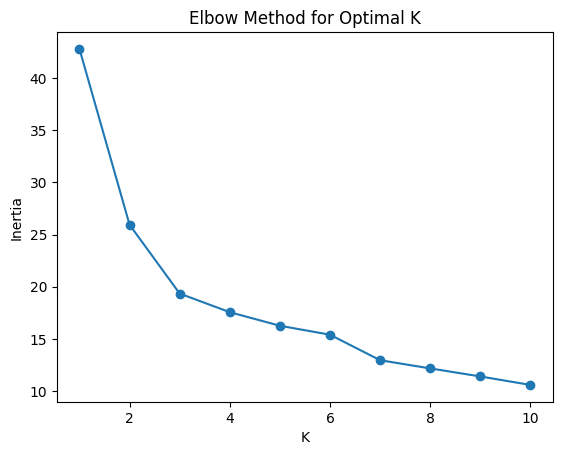

In [39]:
# Plot elbow curve
def eval_Kmeans(x, k, r):
    kmeans = KMeans(n_clusters=k, random_state=r, max_iter=500)
    kmeans.fit(x)
    return kmeans.inertia_

def elbow_Kmeans(x, max_k=10, r=42):
    within_cluster_vars = []
    for k in range(1, max_k+1):
        kmeans = KMeans(n_clusters=k, random_state=r, max_iter=500)
        kmeans.fit(x)
        within_cluster_vars.append(kmeans.inertia_)
    
    plt.plot(range(1, max_k+1), within_cluster_vars, marker='o')
    plt.xlabel('K')
    plt.ylabel('Inertia')
    plt.title('Elbow Method for Optimal K')
    plt.show()

elbow_Kmeans(df_scaled)

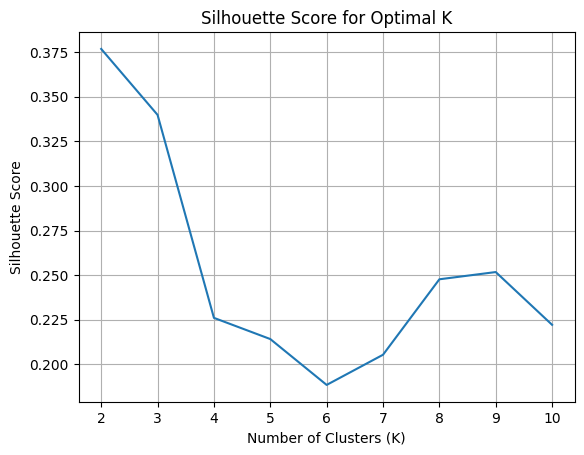

In [40]:
# Silhouette score method
kmax = 10
sil = []
plt.plot()
for k in range(2, kmax+1):
    kmeans = KMeans(n_clusters=k, random_state=rseed, max_iter=500)
    kmeans.fit(df_scaled)
    labels = kmeans.labels_
    sil.append(silhouette_score(df_scaled, labels, metric='euclidean'))

sns.lineplot(x=range(2, kmax+1), y=sil)
plt.title('Silhouette Score for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

Based on the elbow and silhouette score method choose a value for K.

## Fitting a K-Means Model with the selected K value

Fit the scaled dataset to the optimal number of clusters. Report back on the silhouette score of the model.

In [19]:
# Remember to set the random_state to rseed
k_optimal = 5
kmeans = KMeans(n_clusters=k_optimal, random_state=42, max_iter=500)
# Fit KMeans clustering model to the scaled data
kmeans.fit(df_scaled)
# Get cluster labels assigned to each data point
labels = kmeans.labels_

# Calculate silhouette score
score = silhouette_score(df_scaled, labels, metric='euclidean')
print(f'Silhouette Score for k={k_optimal}: {score}')

Silhouette Score for k=5: 0.21419732416980747


Based on the elbow method and silhouette score, assume the optimal number of clusters is determined to be 𝑘=5.

In [36]:
# Count the number of records in each cluster
cluster_counts = pd.Series(labels).value_counts().sort_index()

# Display the counts of records in each cluster
print("Number of records in each cluster:")
print(cluster_counts)

Number of records in each cluster:
0    55
1    43
2    10
3    26
4    33
Name: count, dtype: int64


In [37]:
# Check model performance with the silhouette coefficient
silhouette_avg = silhouette_score(df_scaled, labels) # Compute the silhouette score
 
# Print the silhouette score
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.21419732416980747


## Predictions

In [22]:
# Add the predicted cluster label column to the original dataframe
df['Cluster'] = labels

## Visualisation of clusters

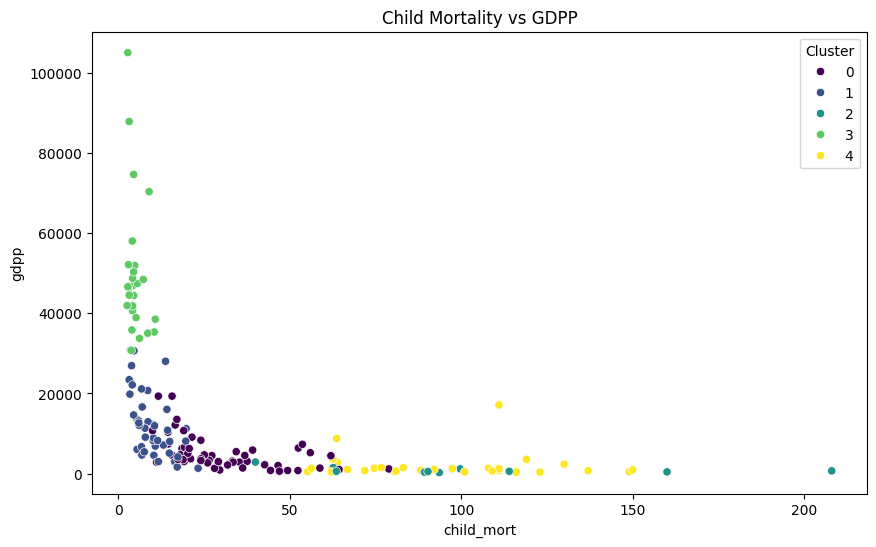

In [23]:
# Visualisation of clusters: child mortality vs gdpp
plt.figure(figsize=(10, 6))
sns.scatterplot(x='child_mort', y='gdpp', hue='Cluster', data=df, palette='viridis')
plt.title('Child Mortality vs GDPP')
plt.show()

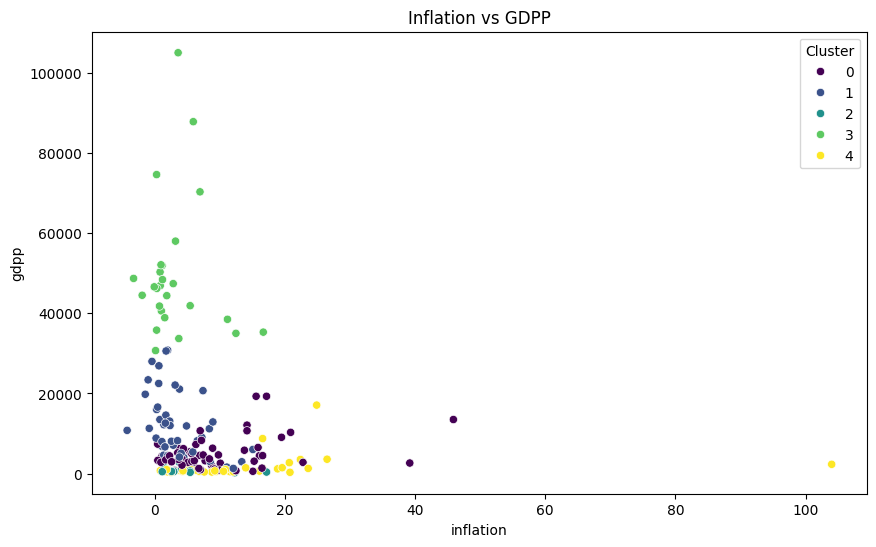

In [24]:
# Visualisation of clusters: inflation vs gdpp
plt.figure(figsize=(10, 6))
sns.scatterplot(x='inflation', y='gdpp', hue='Cluster', data=df, palette='viridis')
plt.title('Inflation vs GDPP')
plt.show()

## Conclusions

Label the groups of countries in the plots you created based on child mortality, GDPP and inflation. You may use [terms](https://en.wikipedia.org/wiki/Developing_country#Terms_used_to_classify_countries) such as: least developed, developing and developed, or low, low-middle, upper-middle and high income. Alternatively, simply rank them from highest to lowest. Justify the labels you assign to each group.


In [25]:
# Label the groups
## Example labeling based on cluster analysis
cluster_labels = {
    0: 'Least Developed',
    1: 'Developing',
    2: 'Developed',
    3: 'High Income',
    4: 'Low Income'
}

# Map the labels to the dataframe
df['Development Status'] = df['Cluster'].map(cluster_labels)

# Display the dataframe with the new labels
print(df[['Cluster', 'Development Status']].head())

                     Cluster Development Status
country                                        
Afghanistan                4         Low Income
Albania                    1         Developing
Algeria                    0    Least Developed
Angola                     4         Low Income
Antigua and Barbuda        1         Developing


**Answer here:**

This approach ensures that the countries are categorized in a meaningful way based on their socio-economic and health factors. And label the groups based on the cluster analysis:


Least Developed: High child mortality, low GDPP, high inflation.


Developing: Moderate child mortality, moderate GDPP, moderate inflation.


Developed: Low child mortality, high GDPP, low inflation.


High Income: Very high GDPP, low child mortality, very low inflation.


Low Income: Low GDPP, moderate to high child mortality, variable inflation.

In [26]:
# Detailed analysis of clusters
for cluster, label in cluster_labels.items():
    print(f"\nCluster {cluster} ({label}):")
    print(df[df['Cluster'] == cluster][['child_mort', 'gdpp', 'inflation']].describe())


Cluster 0 (Least Developed):
       child_mort          gdpp  inflation
count   55.000000     55.000000  55.000000
mean    30.887273   4955.127273   9.870382
std     15.656392   4122.818090   8.501235
min     10.000000    592.000000   0.480000
25%     18.850000   2625.000000   4.335000
50%     26.500000   3650.000000   7.200000
75%     38.400000   6240.000000  14.200000
max     78.900000  19300.000000  45.900000

Cluster 1 (Developing):
       child_mort          gdpp  inflation
count   43.000000     43.000000  43.000000
mean    10.004651  12289.069767   3.582070
std      5.167433   8003.854671   4.151696
min      3.200000   1310.000000  -4.210000
25%      6.000000   6355.000000   0.965500
50%      8.700000  11200.000000   2.330000
75%     14.000000  16300.000000   5.395000
max     23.300000  30800.000000  15.100000

Cluster 2 (Developed):
       child_mort         gdpp  inflation
count   10.000000    10.000000  10.000000
mean   102.120000   873.700000   5.665000
std     49.419897   7